# 基于第三方模型自动集成进行时序建模

PaddleTS集成了 [scikit-learn][scikit-learn Link] 和 [pyod][pyod Link] 第三方库。在该文档中，我们将介绍如何使用PaddleTS的[第三方模型自动集成][paddlets Link]能力构建时序模型。

主要内容包括：  
1. 基于第三方模型进行时序预测
2. 基于第三方模型进行时序异常检测

[scikit-learn Link]: https://scikit-learn.org/stable/index.html
[pyod Link]: https://pyod.readthedocs.io/en/latest/index.html
[paddlets Link]: https://github.com/PaddlePaddle/PaddleTS/blob/main/paddlets/models/ml_model_wrapper.py#L881

# 1. 基于第三方模型进行时序预测

第一部分会基于 [scikit-learn][scikit-learn Link] 第三方模型构建时序预测模型。步骤包括：

- 1.1 数据导入
- 1.2.数据查看
- 1.3 数据预处理
- 1.4 模型构建
- 1.5 模型训练
- 1.6 模型预测与评估
- 1.7 模型保存  
- 1.8 模型加载及推理
- 1.9 （可选）自定义样本数据构建函数

[scikit-learn Link]: https://scikit-learn.org/stable/index.html

## 1.1 数据导入

可以直接使用PaddleTS集成的公开数据集，也可以导入自己的数据（如何导入自己的数据请参考TSDataset相关使用文档）  

在这个例子里面，示例数据集是一份包含了2010年至2014年的关于天气的单变量数据，其中 WetBulbCelsuis 代表湿球温度。可通过下面代码导入： 

In [2]:
from paddlets.datasets.repository import get_dataset

tsdataset = get_dataset("UNI_WTH")

## 1.2 数据查看

PaddleTS提供了统一的TSDataset数据集接口描述时序数据。对于导入完成的数据集，可以调用TSDataset提供的接口查看数据的基本情况。

从下方代码运行结果看出，该数据的起始时间为2010-01-01 00:00:00，结束时间为2013-12-31 23:00:00，时间点频率为小时级（H）。

In [3]:
print(f"start time: {tsdataset.target.start_time}")
print(f"end time: {tsdataset.target.end_time}")
print(f"frequency: {tsdataset.target.freq}")

start time: 2010-01-01 00:00:00
end time: 2013-12-31 23:00:00
frequency: H


也可通过TSDataset.plot接口可视化查看数据集。

<AxesSubplot:xlabel='date'>

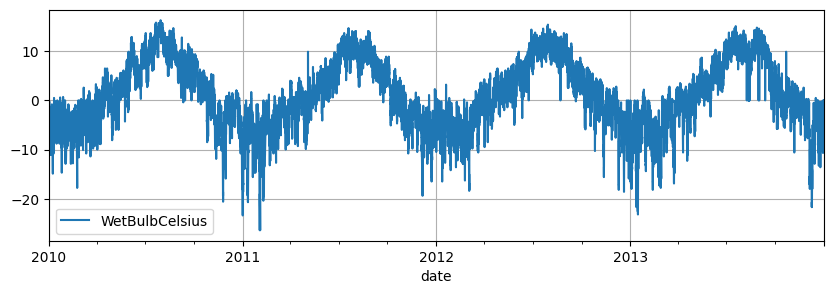

In [4]:
tsdataset.plot()

## 1.3 数据预处理

在建模之前，确定训练集和测试集。在该示例中使用前65%数据用于训练，后35%数据用于测试。

In [5]:
from paddlets.transform import StandardScaler

# 数据集拆分
train_tsdataset, test_tsdataset = tsdataset.split(split_point=0.65)

确认训练集和数据集之后，我们对数据进行标准化处理。

In [6]:
# 数据标准化
scaler = StandardScaler()
scaler.fit(train_tsdataset)
train_tsdataset_scaled = scaler.transform(train_tsdataset)
test_tsdataset_scaled = scaler.transform(test_tsdataset)

## 1.4 模型构建

完成数据预处理之后，我们需要构建时序预测模型。在该示例中，我们会基于[sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)构建时序预测模型。

构建方式非常简单，调用PaddleTS提供的模型构建接口，传入希望使用的第三方模型以及时序相关参数即可。这里我们假定希望模型使用过去的3个时间点去预测未来的1个时间点：

In [7]:
from paddlets.models.ml_model_wrapper import make_ml_model

from sklearn.neighbors import KNeighborsRegressor

forecasting_model = make_ml_model(
    model_class=KNeighborsRegressor,
    in_chunk_len=3,
    out_chunk_len=1
)

## 1.5 模型训练

完成模型构建和数据处理后，即可进行模型训练。

In [8]:
import numpy as np

np.random.seed(2022)
forecasting_model.fit(train_data=train_tsdataset_scaled)

## 1.6 模型预测与评估

模型训练完成之后，可以对测试集进行预测并评估。   

PaddleTS的 [metrics][metrics Link] 模块提供了多种评估指标，该示例中采用MAE。

[metrics Link]: https://github.com/PaddlePaddle/PaddleTS/blob/main/paddlets/metrics/metrics.py

In [9]:
from paddlets.metrics import MAE

# 预测
y_pred = forecasting_model.predict(train_tsdataset_scaled)

# 基于真实数据和预测结果，计算MAE评估指标
y_true, _ = test_tsdataset_scaled.split(test_tsdataset_scaled.target.time_index[0])

mae = MAE()
metric_res = mae(tsdataset_true=y_true, tsdataset_pred=y_pred)
print(f"mae: {metric_res}")

mae: {'WetBulbCelsius': 0.032317469862445325}


## 1.7 模型保存

模型训练完成之后，可以将其保存到指定路径。

In [10]:
forecasting_model.save("./forecasting_model")

## 1.8 模型加载及推理

可以加载已保存的模型用于新数据的预测

In [11]:
from paddlets.models.model_loader import load

loaded_forecasting_model = load("./forecasting_model")
pred_tsdataset = loaded_forecasting_model.predict(test_tsdataset_scaled)
print(pred_tsdataset)

            WetBulbCelsius
2014-01-01       -0.400627


## 1.9 自定义样本数据构建函数

一些第三方库（如 scikit-learn ）的机器学习模型通常会接收numpy.ndarray类型数据作为 fit 和 predict 方法的输入。但是在PaddleTS中，会使用 paddlets.models.forecasting.ml.adapter.ml_dataloader.MLDataLoader 表示可用于训练/预测的时序数据。

因此，make_ml_model 提供了 udf_ml_dataloader_to_fit_ndarray 和 udf_ml_dataloader_to_predict_ndarray 两个可选参数，用于支持用户将 MLDataLoader 转换为 numpy.ndarray 数据对象。

make_ml_model 默认会使用 default_sklearn_ml_dataloader_to_fit_ndarray 和 default_sklearn_ml_dataloader_to_predict_ndarray 两个函数将 MLDataLoader 分别转换为 fit 和 predict 方法可接收的 numpy.ndarray 数据。同时，用户也可以开发自定义的数据转换函数，用于得到可用于训练/预测的数据。

### 1.9.1 自定义udf函数

下方示例展示了如何定义2个udf函数，需要注意的是，由于这个小节的主要目的是为了说明如何使用自定义udf函数这个功能。因此，下方示例的函数逻辑与PaddleTS提供的默认函数逻辑几乎相同。

In [12]:
from typing import Tuple, Any, Optional, Dict
import numpy as np
import itertools


def udf_sklearn_ml_dataloader_to_fit_ndarray(
    ml_dataloader: "MLDataLoader",
    model_init_params: Dict[str, Any],
    in_chunk_len: int,
    skip_chunk_len: int,
    out_chunk_len: int
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    udf函数，自定义fit接口的数据构建逻辑。
    """
    data = next(ml_dataloader)

    sample_x_keys = data.keys() - {"future_target"}
    if in_chunk_len < 1:
        sample_x_keys -= {"past_target"}
    full_ordered_x_key_list = ["past_target"]
    full_ordered_x_key_list.extend(
        [f"{t[1]}_{t[0]}" for t in itertools.product(["numeric", "categorical"], ["known_cov", "observed_cov", "static_cov"])]
    )
    
    actual_ordered_x_key_list = []
    for k in full_ordered_x_key_list:
        if k in sample_x_keys:
            actual_ordered_x_key_list.append(k)

    reshaped_x_ndarray_list = []
    for k in actual_ordered_x_key_list:
        ndarray = data[k]
        reshaped_ndarray = ndarray.reshape(ndarray.shape[0], ndarray.shape[1] * ndarray.shape[2])
        reshaped_x_ndarray_list.append(reshaped_ndarray)
    
    x = np.hstack(tup=reshaped_x_ndarray_list)
    y = np.squeeze(data["future_target"])
    return x, y


def udf_sklearn_ml_dataloader_to_predict_ndarray(
    ml_dataloader: "MLDataLoader",
    model_init_params: Dict[str, Any],
    in_chunk_len: int,
    skip_chunk_len: int,
    out_chunk_len: int
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    udf函数，自定义predict接口的数据构建逻辑。
    """
    data = next(ml_dataloader)

    sample_x_keys = data.keys() - {"future_target"}
    if in_chunk_len < 1:
        sample_x_keys -= {"past_target"}
    full_ordered_x_key_list = ["past_target"]
    full_ordered_x_key_list.extend(
        [f"{t[1]}_{t[0]}" for t in itertools.product(["numeric", "categorical"], ["known_cov", "observed_cov", "static_cov"])]
    )
    
    actual_ordered_x_key_list = []
    for k in full_ordered_x_key_list:
        if k in sample_x_keys:
            actual_ordered_x_key_list.append(k)

    reshaped_x_ndarray_list = []
    for k in actual_ordered_x_key_list:
        ndarray = data[k]
        reshaped_ndarray = ndarray.reshape(ndarray.shape[0], ndarray.shape[1] * ndarray.shape[2])
        reshaped_x_ndarray_list.append(reshaped_ndarray)
    
    x = np.hstack(tup=reshaped_x_ndarray_list)
    return x, None

### 1.9.2 使用udf函数作为可选参数构建时序预测模型

In [13]:
forecasting_model_with_udf_fn = make_ml_model(
    model_class=KNeighborsRegressor,
    in_chunk_len=3,
    out_chunk_len=1,
    udf_ml_dataloader_to_fit_ndarray=udf_sklearn_ml_dataloader_to_fit_ndarray,
    udf_ml_dataloader_to_predict_ndarray=udf_sklearn_ml_dataloader_to_predict_ndarray
)

### 1.9.3 训练与预测

模型构建完成后，训练与预测的步骤与上文 1.4 - 1.6 完全相同。

In [14]:
# 训练
forecasting_model_with_udf_fn.fit(train_data=train_tsdataset_scaled)

# 预测
y_pred = forecasting_model_with_udf_fn.predict(train_tsdataset_scaled)
print(y_pred)

                     WetBulbCelsius
2012-08-07 15:00:00        1.702946


# 2. 基于第三方模型进行时序异常检测

这部分会基于 [pyod][pyod Link] 第三方模型构建时序异常检测模型。步骤包括：

- 2.1 数据导入
- 2.2 数据查看
- 2.3 数据预处理
- 2.4 模型构建
- 2.5 模型训练
- 2.6 模型预测与评估
- 2.7 模型结果可视化
- 2.8 模型保存  
- 2.9 模型加载及推理
- 2.10 （可选）自定义样本数据构建函数

[pyod Link]: https://pyod.readthedocs.io/en/latest/

## 2.1 数据导入

使用PaddleTS内置的公开数据集NAB。可通过下方代码导入：  

In [15]:
from paddlets.datasets.repository import get_dataset

tsdataset = get_dataset('NAB_TEMP')

## 1.2 数据查看

PaddleTS提供了异常检测数据的可视化接口，用户查看数据情况，见下方示例代码：

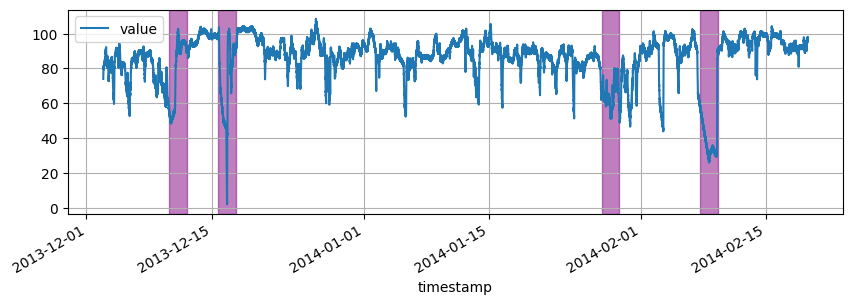

In [16]:
from paddlets.utils.utils import plot_anoms

plot_anoms(origin_data=tsdataset, feature_name="value")

## 2.3 数据预处理

在建模之前，确定训练集和测试集。在该示例中使用前15%数据用于训练，后85%数据用于测试。

In [17]:
from paddlets.transform import StandardScaler

# 数据集拆分
train_tsdataset, test_tsdataset = tsdataset.split(0.15)

# 标准化
scaler = StandardScaler()
scaler.fit(train_tsdataset)
train_tsdataset_scaled = scaler.transform(train_tsdataset)
test_tsdataset_scaled = scaler.transform(test_tsdataset)

## 2.4 模型构建

完成数据预处理之后，我们需要构建时序预测模型。在该示例中，我们会基于 [pyod.models.pca.PCA][pca Link] 构建时序异常检测模型。这里假定样本窗口大小为2。

[pca Link]: https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.pca.PCA

In [18]:
from paddlets.models.ml_model_wrapper import make_ml_model

from pyod.models.pca import PCA

anomaly_model = make_ml_model(model_class=PCA, in_chunk_len=2)

## 2.5 模型训练

完成模型构建和数据处理后，即可进行模型训练。

In [19]:
import numpy as np

np.random.seed(2022)
anomaly_model.fit(train_data=train_tsdataset_scaled)

## 2.6 模型预测与评估

模型训练完成之后，可以对测试集进行预测并评估。   

PaddleTS的 [metrics][metrics Link] 模块提供了多种评估指标，该示例中采用F1，Precision，Recall三个指标进行评估。

[metrics Link]: https://github.com/PaddlePaddle/PaddleTS/blob/main/paddlets/metrics/metrics.py

In [20]:
from paddlets.metrics import F1, Precision, Recall

# 预测
pred_label = anomaly_model.predict(test_tsdataset_scaled)
lable_name = pred_label.target.data.columns[0]

# 计算评估指标
f1 = F1()
f1_metric_res = f1(tsdataset_true=test_tsdataset, tsdataset_pred=pred_label)

precision = Precision()
precision_metric_res = precision(tsdataset_true=test_tsdataset, tsdataset_pred=pred_label)

recall = Recall()
recall_metric_res = recall(tsdataset_true=test_tsdataset, tsdataset_pred=pred_label)

print (f"f1 metric: {f1_metric_res[lable_name]}")
print (f"precision metric: {precision_metric_res[lable_name]}")
print (f"recall metric: {recall_metric_res[lable_name]}")

[2022-11-02 19:19:17,164] [paddlets.metrics.base] [WARNING] Tsdataset true's and pred's time_index do not match, the result will be calculated according to the intersection!
[2022-11-02 19:19:17,184] [paddlets.metrics.base] [WARNING] Tsdataset true's and pred's time_index do not match, the result will be calculated according to the intersection!
[2022-11-02 19:19:17,201] [paddlets.metrics.base] [WARNING] Tsdataset true's and pred's time_index do not match, the result will be calculated according to the intersection!


f1 metric: 0.5914179104477612
precision metric: 0.6277227722772277
recall metric: 0.5590828924162258


## 2.7 模型结果可视化 

可以将模型的预测结果和真实异常做对比，更加直观的查看模型预测的效果

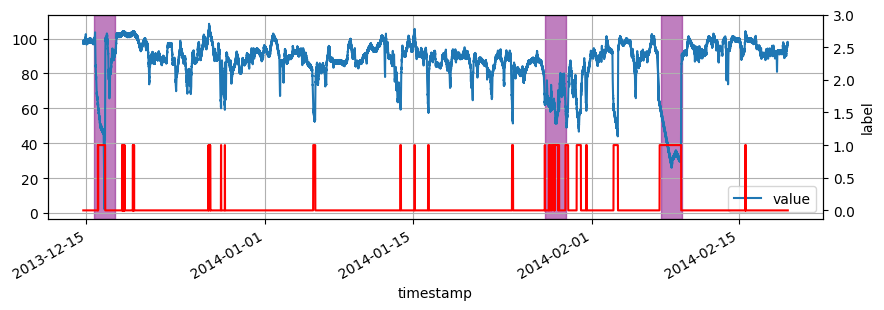

In [21]:
plot_anoms(origin_data=test_tsdataset, predict_data=pred_label, feature_name="value")

在异常检测场景中，PaddleTS除了提供predict接口预测每个时间点是否异常，还提供了predict_score接口获得每个时间点的异常分数，分数越高，表示该点越可能是异常。见下方示例代码：

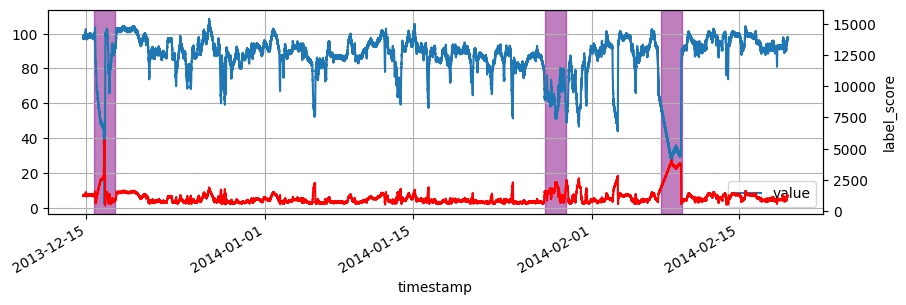

In [22]:
# 异常评分与真实值
pred_score = anomaly_model.predict_score(test_tsdataset_scaled)
plot_anoms(origin_data=test_tsdataset, predict_data=pred_score, feature_name="value")

## 2.8 模型保存

模型训练完成之后，可以将其保存到指定路径。

In [23]:
anomaly_model.save('./anomaly_pca_model')

## 2.9 模型加载及推理

可以加载已保存的模型用于新数据的预测：

In [24]:
from paddlets.models.model_loader import load

loaded_anomaly_model = load("./anomaly_pca_model")
pred_label = loaded_anomaly_model.predict(test_tsdataset_scaled)
print(f"pred_label: \n{pred_label}")

pred_score = loaded_anomaly_model.predict_score(test_tsdataset_scaled)
print(f"pred_score: \n{pred_score}")

pred_label: 
                     label
timestamp                 
2013-12-14 16:55:00      0
2013-12-14 17:00:00      0
2013-12-14 17:05:00      0
2013-12-14 17:10:00      0
2013-12-14 17:15:00      0
...                    ...
2014-02-19 15:05:00      0
2014-02-19 15:10:00      0
2014-02-19 15:15:00      0
2014-02-19 15:20:00      0
2014-02-19 15:25:00      0

[19279 rows x 1 columns]
pred_score: 
                     label_score
timestamp                       
2013-12-14 16:55:00  1221.563650
2013-12-14 17:00:00  1257.307292
2013-12-14 17:05:00  1272.464580
2013-12-14 17:10:00  1188.761339
2013-12-14 17:15:00  1256.563297
...                          ...
2014-02-19 15:05:00  1213.258473
2014-02-19 15:10:00  1248.840452
2014-02-19 15:15:00  1223.282235
2014-02-19 15:20:00  1200.807306
2014-02-19 15:25:00  1233.421097

[19279 rows x 1 columns]


验证加载的模型的预测结果，与保存前的结果一致：

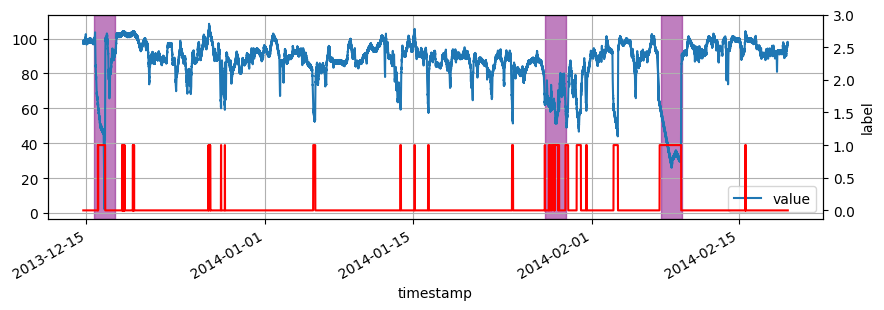

In [25]:
plot_anoms(origin_data=test_tsdataset, predict_data=pred_label, feature_name="value")

## 2.10 自定义样本数据构建函数

这部分内容与时序预测模型的处理方式相同，可参考上文 1.9 小节。